# How to use the prebuilt ReAct agent

In this how-to we'll create a simple [ReAct](https://arxiv.org/abs/2210.03629) agent app that can check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:  

1. If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
2. If the agent did not ask to run tools, we will finish (respond to the user)

<div class="admonition warning">
    <p class="admonition-title">Prebuilt Agent</p>
    <p>
Please note that here will we use a prebuilt agent. One of the big benefits of LangGraph is that you can easily create your own agent architectures. So while it's fine to start here to build an agent quickly, we would strongly recommend learning how to build your own agent so that you can take full advantage of LangGraph. Read <a href="https://langchain-ai.github.io/langgraphjs/tutorials/quickstart/#quickstart"> this guide </a> to learn how to create your own ReAct agent from scratch.
    </p>
</div>   

## Setup

First, we need to install the required packages.

```bash
yarn add @langchain/langgraph @langchain/openai @langchain/core
```

This guide will use OpenAI's GPT-4o model. We will optionally set our API key
for [LangSmith tracing](https://smith.langchain.com/), which will give us
best-in-class observability.

In [ ]:
// process.env.OPENAI_API_KEY = "sk_...";

// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__..."
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
process.env.LANGCHAIN_TRACING_V2 = "true";
process.env.LANGCHAIN_PROJECT = "ReAct Agent: LangGraphJS";

ReAct Agent: LangGraphJS


## Code

Now we can use the prebuilt `createReactAgent` function to setup our agent:

In [17]:
import { ChatOpenAI } from "@langchain/openai";
import { tool } from '@langchain/core/tools';
import { z } from 'zod';
import { createReactAgent } from "@langchain/langgraph/prebuilt";

const model = new ChatOpenAI({
  model: "gpt-4o",
});

const getWeather = tool((input) => {
  if (['sf', 'san francisco', 'san francisco, ca'].includes(input.location.toLowerCase())) {
    return 'It\'s 60 degrees and foggy.';
  } else {
    return 'It\'s 90 degrees and sunny.';
  }
}, {
  name: 'get_weather',
  description: 'Call to get the current weather.',
  schema: z.object({
    location: z.string().describe("Location to get the weather for."),
  })
})

const agent = createReactAgent({ llm: model, tools: [getWeather] });

## Usage

First, let's visualize the graph we just created

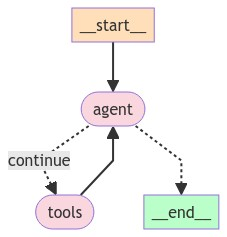

In [18]:
import * as tslab from "tslab";

const graph = agent.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

Let's run the app with an input that needs a tool call

In [19]:
let inputs = { messages: [{ role: "user", content: "what is the weather in SF?" }] };

let stream = await agent.stream(inputs, {
  streamMode: "values",
});

for await (const { messages } of stream) {
  let msg = messages[messages?.length - 1];
  if (msg?.content) {
    console.log(msg.content);
  } else if (msg?.tool_calls?.length > 0) {
    console.log(msg.tool_calls);
  } else {
    console.log(msg);
  }
  console.log("-----\n");
}

what is the weather in sf?
-----

[
  {
    name: 'get_weather',
    args: { location: 'San Francisco, CA' },
    type: 'tool_call',
    id: 'call_wfXCh5IhSp1C0Db3gaJWDbRP'
  }
]
-----

It's 60 degrees and foggy.
-----

The weather in San Francisco is currently 60 degrees and foggy.
-----



Now let's try a question that doesn't need tools

In [20]:
inputs = { messages: [{ role: "user", content: "who built you?" }] };

stream = await agent.stream(inputs, {
  streamMode: "values",
});

for await (
  const { messages } of stream
) {
  let msg = messages[messages?.length - 1];
  if (msg?.content) {
    console.log(msg.content);
  } else if (msg?.tool_calls?.length > 0) {
    console.log(msg.tool_calls);
  } else {
    console.log(msg);
  }
  console.log("-----\n");
}

who built you?
-----

I was developed by OpenAI, an AI research and deployment company.
-----



Perfect! The agent correctly didn't call any tools and instead directly responded to the user.